# Workflow
1. EDA
2. Baseline Model
    - Early stopping
    - Initial bias 
2. Imbalanced data Model
    - Class weights
    - Oversampling

# 1. EDA

#### 데이터 확인

In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


#### 불균형 확인

In [ ]:
neg, pos = np.bincount(raw_df['Class'])

In [ ]:
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



#### EDA
- time은 의미가 없다고 판단하여 삭제
- Amount의 범위를 축소: log 변환(0의 경우를 위해 eps 추가)

In [ ]:
cleaned_df = raw_df.copy()

cleaned_df.pop('Time')

eps=0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

#### 훈련/검증/테스트셋 분할

In [ ]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

#### 데이터 정규화
- 컬럼간의 scale 차이가 큼

In [ ]:
train_df.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
V1,182276.0,-0.001278,1.964659,-56.407510,-0.923381,0.019477,1.315335,2.451888
V2,182276.0,-0.002068,1.663444,-72.715728,-0.598190,0.065282,0.803850,19.167239
V3,182276.0,-0.001844,1.514909,-48.325589,-0.891542,0.179232,1.024355,4.226108
V4,182276.0,0.000021,1.417266,-5.683171,-0.849520,-0.020897,0.743670,16.491217
V5,182276.0,0.003375,1.402235,-113.743307,-0.690388,-0.053259,0.615446,34.801666


- 데이터 표준화
- np.clip으로 minmax 범위 제약

In [ ]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


In [ ]:
pd.DataFrame(train_features).describe().T.head()

,count,mean,std,min,25%,50%,75%,max
0,182276.0,0.009659,0.919213,-5.000000,-0.469347,0.010564,0.670150,1.248651
1,182276.0,0.012138,0.862333,-5.000000,-0.358367,0.040488,0.484488,5.000000
2,182276.0,0.005746,0.949638,-5.000000,-0.587297,0.119529,0.677401,2.790903
3,182276.0,-0.000970,0.993906,-4.009978,-0.599424,-0.014760,0.524708,5.000000
4,182276.0,0.002128,0.889064,-5.000000,-0.494757,-0.040388,0.436498,5.000000


#### 데이터 분포
- 예) V5 / V6
- positive class와 negative class 모두 0을 중심으로 데이터가 모여있음
- positive class에서 극단값이 확인됨 -> 극단값이 희박함을 구분할 수 있는 부분?
- negative class에서는 극단값이 희박함

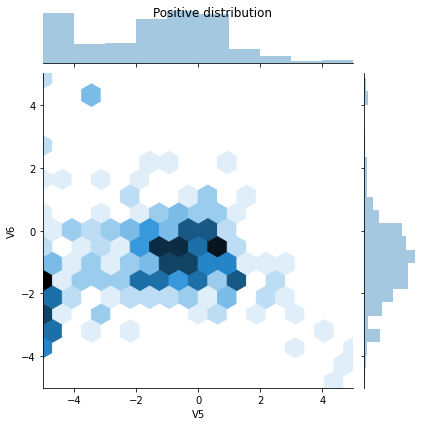

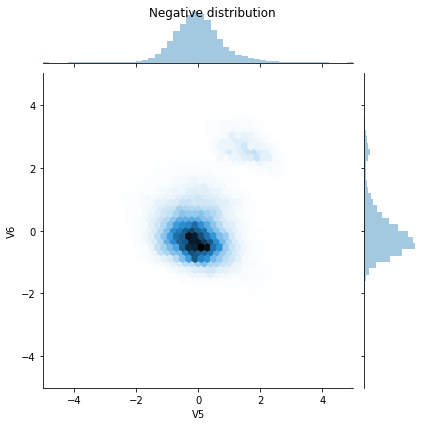

In [ ]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns = train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns = train_df.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
_ = plt.suptitle("Negative distribution")

# 2. Baseline Model

#### Early stopping
모델의 성능이 어느 수준에서 향상되지 않으면, 모델은 정해진 step/epoch을 모두 수행하기 전에 학습을 중단할 수 있다.

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

#### Metrics

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

#### Basline 모델
구성된 네트워크는 초기 가중치/bias 값을 포함한다. 데이터 학습을 진행하지 않으면, 초기 가중치/bias로 분류를 진행하는 basline 모델로 사용할 수 있다.

In [ ]:
def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
    ])

    model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

In [ ]:
EPOCHS = 100
BATCH_SIZE = 2048

model = make_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                480       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.predict(train_features[:10])

array([[0.64617527],
       [0.139029  ],
       [0.59942526],
       [0.3077045 ],
       [0.21643874],
       [0.19505093],
       [0.17844442],
       [0.53233063],
       [0.5330122 ],
       [0.68878907]], dtype=float32)

In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6585


#### 초기 바이어스 설정
output layer의 bias를 초기값 대신에, Imbalanced data를 반영하여, 조정할 수 있다. 이는 모델의 빠른 수렴에 도움이 된다. 

['기본 바이어스 초기화'](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)를 사용하면 손실은 약 math.log(2) = 0.69314 <- **공부필요**


In [ ]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

In [ ]:
model = make_model(output_bias = initial_bias)
model.predict(train_features[:10])

array([[0.00168356],
       [0.00928283],
       [0.0007906 ],
       [0.00169283],
       [0.00993705],
       [0.00437078],
       [0.00195053],
       [0.00127891],
       [0.00062457],
       [0.00677922]], dtype=float32)

학습을 하지 않았지만, output layer의 초기 bias 수정만으로 loss가 감소함

In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0241


#### 초기 가중치 저장

In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

#### 모델 비교 학습
- zero_bias_history
    - final output의 initial bias를 0으로 설정
- careful_bias_history
    - final output의 initial bias를 imbalanced bias로 설정
    
- validation_data: 학습 및 평가를 동시에 진행하여 학습 history를 반환

In [ ]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [ ]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

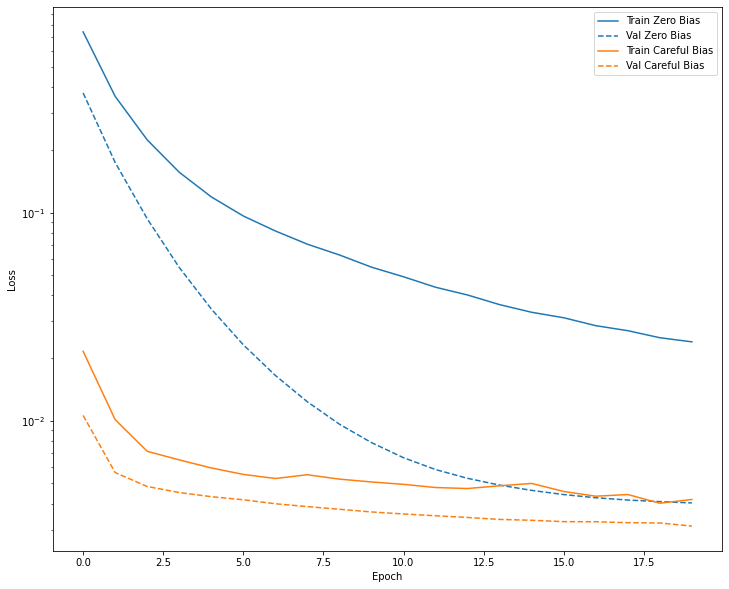

In [ ]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

#### 모델 학습 히스토리 확인

In [ ]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
90/90 [==============================] - 3s 17ms/step - loss: 0.0263 - tp: 92.6264 - fp: 1244.0769 - tn: 149597.0989 - fn: 168.7692 - accuracy: 0.9895 - precision: 0.0694 - recall: 0.4126 - auc: 0.6223 - val_loss: 0.0105 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 45493.0000 - val_fn: 76.0000 - val_accuracy: 0.9983 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7867
Epoch 2/100
90/90 [==============================] - 1s 9ms/step - loss: 0.0112 - tp: 37.6593 - fp: 12.3077 - tn: 93954.2637 - fn: 136.3407 - accuracy: 0.9984 - precision: 0.7781 - recall: 0.2026 - auc: 0.7831 - val_loss: 0.0054 - val_tp: 35.0000 - val_fp: 5.0000 - val_tn: 45488.0000 - val_fn: 41.0000 - val_accuracy: 0.9990 - val_precision: 0.8750 - val_recall: 0.4605 - val_auc: 0.8799
Epoch 3/100
90/90 [==============================] - 1s 9ms/step - loss: 0.0078 - tp: 78.0220 - fp: 17.1538 - tn: 93959.0989 - fn: 86.2967 - accuracy: 0.9989 - precision: 0.8216 - recall: 0.4676 - auc: 0

baseline_history 다음과 같은 값을 포함하고 있다
- baseline_history.epoch: 에폭 수
- baseline_history.history: train/val metric

In [ ]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

    plt.legend()

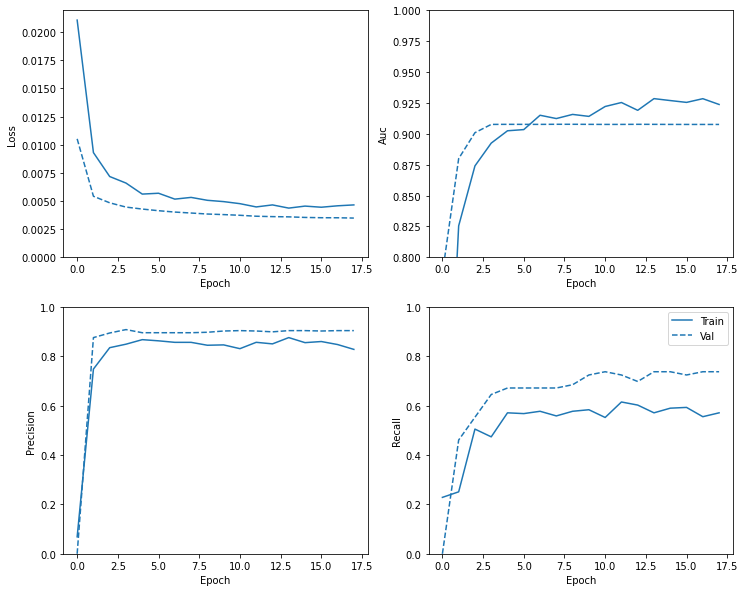

In [ ]:
plot_metrics(baseline_history)

In [ ]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [ ]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

#### 결과 해석
- 실제로 0 인데 1로 예측한 결과(FP): 10
    - 상황에 따라서 증가해도 좋을 수 있는 오류
    - fraud detection에서는 정상거래를 이상거래로 감지 후 고객에게 확인을 위한 연락을 한다고 해도 큰 문제를 야기하진 않음

- 실제로 1 인데 0로 예측한 결과(FN): 25 
    - 데이터 불균형으로 인하여 필연적으로 나올 수 밖에 없는 부분
    - 불균형 데이터 모델에서는 이 부분을 줄여야, minor class 검출에 도움이 된다 

- FP와 FN은 trade-off 관계이기 때문에, 적절한 조율이 필요

loss :  0.0033386547584086657
tp :  72.0
fp :  10.0
tn :  56855.0
fn :  25.0
accuracy :  0.9993855357170105
precision :  0.8780487775802612
recall :  0.7422680258750916
auc :  0.9379306435585022

Legitimate Transactions Detected (True Negatives):  56855
Legitimate Transactions Incorrectly Detected (False Positives):  10
Fraudulent Transactions Missed (False Negatives):  25
Fraudulent Transactions Detected (True Positives):  72
Total Fraudulent Transactions:  97


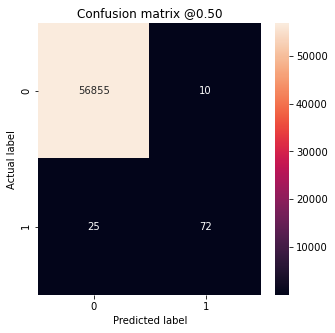

In [ ]:
baseline_results = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

# 3. Imbalanced data model

#### 클래스 가중치
- 클래스의 비율에 반비례하는 클래스 가중치를 계산

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


#### 클래스 가중치 모델 적용
- 초기 bias처럼 클래스 가중치를 적용할 수 있다

- 참고 : class_weights 사용하면 손실 범위가 변경됩니다. 이는 최적화 프로그램에 따라 훈련의 안정성에 영향을 미칠 수 있습니다. optimizers.SGD와 같이 단계 크기가 기울기의 크기에 의존하는 optimizers.SGD 은 실패 할 수 있습니다. 여기에 사용 optimizers.Adam 은 스케일링 변경의 영향을받지 않습니다. 또한 가중치 때문에 총 손실은 두 모델간에 비교할 수 없습니다

In [ ]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/100
90/90 [==============================] - 3s 17ms/step - loss: 4.2915 - tp: 80.5165 - fp: 322.6374 - tn: 150515.6044 - fn: 183.8132 - accuracy: 0.9970 - precision: 0.2686 - recall: 0.3438 - auc: 0.7134 - val_loss: 0.0138 - val_tp: 13.0000 - val_fp: 28.0000 - val_tn: 45465.0000 - val_fn: 63.0000 - val_accuracy: 0.9980 - val_precision: 0.3171 - val_recall: 0.1711 - val_auc: 0.8628
Epoch 2/100
90/90 [==============================] - 1s 8ms/step - loss: 1.4053 - tp: 70.6154 - fp: 751.7253 - tn: 93220.8791 - fn: 97.3516 - accuracy: 0.9914 - precision: 0.0896 - recall: 0.4007 - auc: 0.8257 - val_loss: 0.0201 - val_tp: 55.0000 - val_fp: 146.0000 - val_tn: 45347.0000 - val_fn: 21.0000 - val_accuracy: 0.9963 - val_precision: 0.2736 - val_recall: 0.7237 - val_auc: 0.9214
Epoch 3/100
90/90 [==============================] - 1s 8ms/step - loss: 0.5827 - tp: 116.7912 - fp: 1255.4066 - tn: 92718.8571 - fn: 49.5165 - accuracy: 0.9864 - precision: 0.0860 - recall: 0.7159 - auc: 0.9118 - va

Epoch 22/100
90/90 [==============================] - 1s 9ms/step - loss: 0.2196 - tp: 144.3516 - fp: 3791.9011 - tn: 90186.0440 - fn: 18.2747 - accuracy: 0.9593 - precision: 0.0362 - recall: 0.8785 - auc: 0.9717 - val_loss: 0.0819 - val_tp: 65.0000 - val_fp: 899.0000 - val_tn: 44594.0000 - val_fn: 11.0000 - val_accuracy: 0.9800 - val_precision: 0.0674 - val_recall: 0.8553 - val_auc: 0.9559
Epoch 23/100
90/90 [==============================] - 1s 8ms/step - loss: 0.2079 - tp: 143.4286 - fp: 3508.8901 - tn: 90472.4835 - fn: 15.7692 - accuracy: 0.9628 - precision: 0.0373 - recall: 0.8981 - auc: 0.9703 - val_loss: 0.0782 - val_tp: 65.0000 - val_fp: 862.0000 - val_tn: 44631.0000 - val_fn: 11.0000 - val_accuracy: 0.9808 - val_precision: 0.0701 - val_recall: 0.8553 - val_auc: 0.9554
Epoch 24/100
90/90 [==============================] - 1s 8ms/step - loss: 0.2006 - tp: 149.9341 - fp: 3401.9890 - tn: 90573.4505 - fn: 15.1978 - accuracy: 0.9638 - precision: 0.0417 - recall: 0.9048 - auc: 0.9726

#### 모델 학습 히스토리 확인

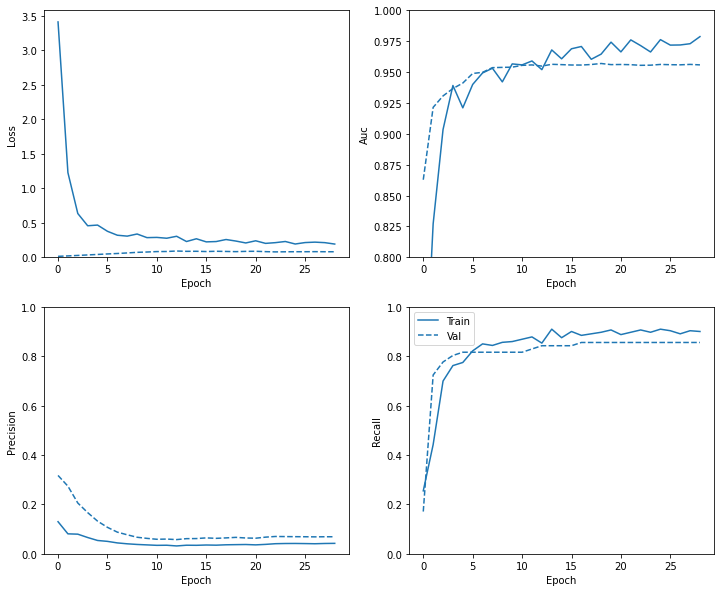

In [ ]:
plot_metrics(weighted_history)

In [ ]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.08301227539777756
tp :  92.0
fp :  1147.0
tn :  55718.0
fn :  5.0
accuracy :  0.9797759652137756
precision :  0.07425343245267868
recall :  0.9484536051750183
auc :  0.9933100342750549

Legitimate Transactions Detected (True Negatives):  55718
Legitimate Transactions Incorrectly Detected (False Positives):  1147
Fraudulent Transactions Missed (False Negatives):  5
Fraudulent Transactions Detected (True Positives):  92
Total Fraudulent Transactions:  97


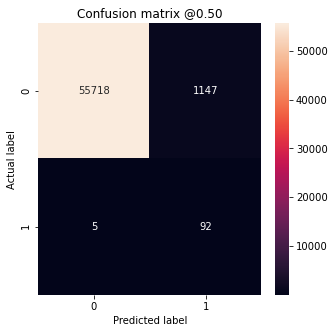

In [ ]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

#### 오버 샘플링
minor 클래스의 데이터 사이즈를 resampling을 통해 키우는 방법

In [ ]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

numpy random choice를 사용하여 데이터를 증가시킬 수 있음

In [ ]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181957, 29)

pandas의 경우 sample 함수에 replacement = True를 이용하여 증가시킬 수 있음

In [ ]:
pd.DataFrame(pos_features).sample(len(neg_features), replace=True).shape

(181957, 29)

tf.Data를 이용하여 증가시킬 수 있음

In [ ]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [ ]:
for features, label in pos_ds.take(1):
    print("Features:\n", features.numpy())
    print()
    print("Label: ", label.numpy())

Features:
 [-2.34961685  2.20354392 -3.49566771  2.73833413 -2.32980533 -0.68514791
 -4.56810904  0.7055391  -2.23482102 -5.          3.4456302  -5.
 -1.01450491 -5.          0.85957336 -5.         -5.         -5.
  1.40389148 -0.44637073  3.70512692 -0.03893996  0.57411054 -0.20593223
 -0.57573741 -0.50029893 -0.45402688 -0.21962909 -1.45244925]

Label:  1


In [ ]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [ ]:
resampled_ds

<PrefetchDataset shapes: ((None, 29), (None,)), types: (tf.float64, tf.int64)>

In [ ]:
for features, label in resampled_ds.take(1):
    print(label.numpy().mean())

0.501953125


epoch 당 단계 수 계산

In [ ]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

#### 오버 샘플링 모델 적용

In [ ]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=val_ds)

Epoch 1/100
278/278 [==============================] - 10s 30ms/step - loss: 1.3246 - tp: 99183.9713 - fp: 69723.9498 - tn: 130102.4695 - fn: 44664.2688 - accuracy: 0.6637 - precision: 0.5215 - recall: 0.6031 - auc: 0.6934 - val_loss: 0.3456 - val_tp: 67.0000 - val_fp: 2586.0000 - val_tn: 42907.0000 - val_fn: 9.0000 - val_accuracy: 0.9431 - val_precision: 0.0253 - val_recall: 0.8816 - val_auc: 0.9491
Epoch 2/100
278/278 [==============================] - 7s 26ms/step - loss: 0.2850 - tp: 128351.2079 - fp: 15785.8889 - tn: 127527.2903 - fn: 15048.2724 - accuracy: 0.8865 - precision: 0.8819 - recall: 0.8932 - auc: 0.9481 - val_loss: 0.1747 - val_tp: 65.0000 - val_fp: 1044.0000 - val_tn: 44449.0000 - val_fn: 11.0000 - val_accuracy: 0.9768 - val_precision: 0.0586 - val_recall: 0.8553 - val_auc: 0.9494
Epoch 3/100
278/278 [==============================] - 7s 27ms/step - loss: 0.2012 - tp: 131056.6272 - fp: 7783.8566 - tn: 135514.5771 - fn: 12357.5986 - accuracy: 0.9282 - precision: 0.9415 

#### 모델 학습 히스토리 확인
- 학습 데이터와 다르게 검증 데이터는 오버 샘플링이 안되었기 때문에 히스토리가 예상과 다르게 나옴

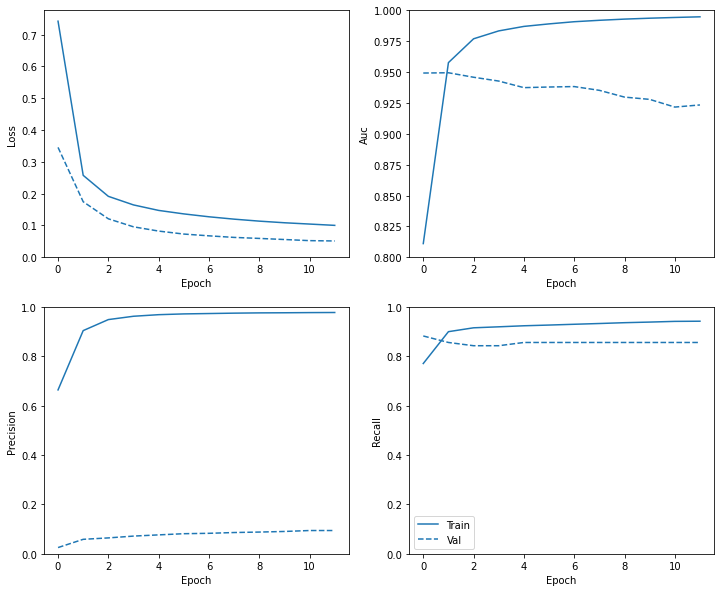

In [ ]:
plot_metrics(resampled_history )

In [ ]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))

Epoch 1/1000
20/20 [==============================] - 5s 147ms/step - loss: 2.8160 - tp: 2987.9048 - fp: 7238.6190 - tn: 49335.0476 - fn: 8437.9048 - accuracy: 0.7844 - precision: 0.2757 - recall: 0.2534 - auc: 0.6273 - val_loss: 0.9861 - val_tp: 9.0000 - val_fp: 29086.0000 - val_tn: 16407.0000 - val_fn: 67.0000 - val_accuracy: 0.3602 - val_precision: 3.0933e-04 - val_recall: 0.1184 - val_auc: 0.1358
Epoch 2/1000
20/20 [==============================] - 1s 33ms/step - loss: 1.7461 - tp: 4847.3810 - fp: 6807.0000 - tn: 4366.3810 - fn: 6409.7143 - accuracy: 0.4026 - precision: 0.4056 - recall: 0.4139 - auc: 0.3768 - val_loss: 0.9719 - val_tp: 56.0000 - val_fp: 29291.0000 - val_tn: 16202.0000 - val_fn: 20.0000 - val_accuracy: 0.3568 - val_precision: 0.0019 - val_recall: 0.7368 - val_auc: 0.6316
Epoch 3/1000
20/20 [==============================] - 1s 33ms/step - loss: 1.1085 - tp: 7106.4762 - fp: 6740.1905 - tn: 4496.9048 - fn: 4086.9048 - accuracy: 0.5107 - precision: 0.5085 - recall: 0.

Epoch 22/1000
20/20 [==============================] - 1s 36ms/step - loss: 0.2494 - tp: 10055.9524 - fp: 1004.0476 - tn: 10253.9048 - fn: 1116.5714 - accuracy: 0.9045 - precision: 0.9080 - recall: 0.8999 - auc: 0.9602 - val_loss: 0.2199 - val_tp: 65.0000 - val_fp: 1224.0000 - val_tn: 44269.0000 - val_fn: 11.0000 - val_accuracy: 0.9729 - val_precision: 0.0504 - val_recall: 0.8553 - val_auc: 0.9508
Epoch 23/1000
20/20 [==============================] - 1s 36ms/step - loss: 0.2445 - tp: 10100.7143 - fp: 923.2381 - tn: 10297.3810 - fn: 1109.1429 - accuracy: 0.9087 - precision: 0.9154 - recall: 0.9006 - auc: 0.9619 - val_loss: 0.2109 - val_tp: 65.0000 - val_fp: 1188.0000 - val_tn: 44305.0000 - val_fn: 11.0000 - val_accuracy: 0.9737 - val_precision: 0.0519 - val_recall: 0.8553 - val_auc: 0.9508
Epoch 24/1000
20/20 [==============================] - 1s 35ms/step - loss: 0.2373 - tp: 10158.6190 - fp: 907.5714 - tn: 10308.0476 - fn: 1056.2381 - accuracy: 0.9125 - precision: 0.9182 - recall: 0.

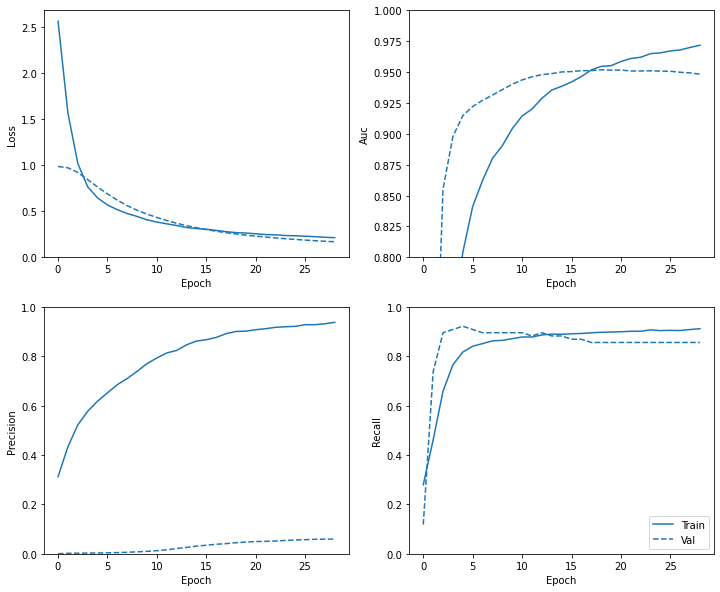

In [ ]:
plot_metrics(resampled_history)

In [ ]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.2532658874988556
tp :  91.0
fp :  1741.0
tn :  55124.0
fn :  6.0
accuracy :  0.9693304300308228
precision :  0.04967248812317848
recall :  0.938144326210022
auc :  0.9870859384536743

Legitimate Transactions Detected (True Negatives):  55124
Legitimate Transactions Incorrectly Detected (False Positives):  1741
Fraudulent Transactions Missed (False Negatives):  6
Fraudulent Transactions Detected (True Positives):  91
Total Fraudulent Transactions:  97


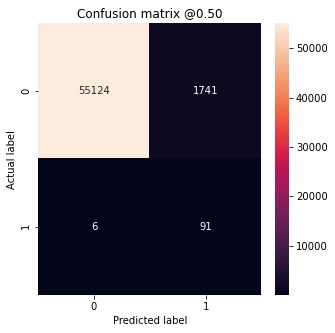

In [ ]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)